In [18]:
import shutil
import os
import glob
from collections import defaultdict
from typing import *

from pathlib import Path
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import cv2

In [8]:
SPLIT_CHAR = "P1K2-RSK12aDf215Zzz"

PATH = Path("../outputs/P1K2-RSK12aDf215ZzzhomeP1K2-RSK12aDf215Zzzihar.khakholkaP1K2-RSK12aDf215ZzzProjectsP1K2-RSK12aDf215ZzzdetAnatorP1K2-RSK12aDf215Zzzexamples/")

In [112]:
# reconstructed path
reconstructed_path = str(PATH).split('/')[-1]
reconstructed_path = '/'.join(reconstructed_path.split(SPLIT_CHAR))
reconstructed_path

'/home/ihar.khakholka/Projects/detAnator/examples'

In [9]:
ls $PATH

retinaface/  scrfd_10g_bnkps/  tinaface_r50_fpn_gn_dcn/


In [119]:
def nms_landmarks(detections: np.ndarray, landmarks: List[bool], thresh_iou: float, min_votes: int = 1) -> List[int]:
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    And keep the ones with landmarks.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [x1, y1, x2, y2, score].
        landmarks: list of indicaters if landmarks are bresented for boxes.
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of boxes need to select
    """
    landmarks = np.array(landmarks)

    # we extract coordinates for every 
    # prediction box present in P
    start_x = detections[:, 0]
    start_y = detections[:, 1]
    end_x = detections[:, 2]
    end_y = detections[:, 3]

    # we extract the confidence scores as well
    scores = detections[:, 4]
    
    # calculate area of every block in P
    areas = (end_x - start_x) * (end_y - start_y)
    
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
    

    while len(order) > 0:
        
        # The index of largest confidence score
        index = order[-1]

        # Compute coordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order])
        x2 = np.minimum(end_x[index], end_x[order])
        y1 = np.maximum(start_y[index], start_y[order])
        y2 = np.minimum(end_y[index], end_y[order])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order] - intersection)
        
        # split by ious
        candidates = np.where(ratio >= thresh_iou)
        left = np.where(ratio < thresh_iou)
        
        
        # Choose the most confident with landmarks
        
        candidate_indexes = order[candidates]
        
        # sort first by confidence then by landmarks. The sorted() alg is stable.
        candidate_indexes = sorted(candidate_indexes, key=lambda i: scores[i], reverse=True)
        candidate_indexes = sorted(candidate_indexes, key=lambda i: landmarks[i], reverse=True)
        
        # update index with one with landmarks
        index = candidate_indexes[0]
        
        # save result
        if len(candidate_indexes) >= min_votes:
            keep.append(index)

        # remove supressed boxes
        order = order[left]

        
    return keep

In [78]:
def parse_line(line: str) -> Tuple[str, List[list], List[list]]:    
    detections = []
    landmarks = []
    
    det_size = 1 + 4 + 10

    img = line.split(' ')[0]
    count = int(line.split(' ')[1])
    line = line.split("$d")[1].strip().split(' ')


    for i in range(count):
        det_raw = line[i*det_size: (i+1)*det_size]
        points = [float(p) for p in det_raw[5:]]
        x1 = min(int(det_raw[1]), int(det_raw[3]))
        x2 = max(int(det_raw[1]), int(det_raw[3]))
        y1 = min(int(det_raw[2]), int(det_raw[4]))
        y2 = max(int(det_raw[2]), int(det_raw[4]))
        score = float(det_raw[0])

        detections.append([x1, y1, x2, y2, score])
        landmarks.append(points)
        
    return img, detections, landmarks


def collect_detections(detections_log: List[str], prefix_path: str = None) -> dict:
    output = dict()
    
    for line in detections_log:        
        img, detections, landmarks = parse_line(line)
        
        if prefix_path:
            img = img[img.find(prefix_path):]
        
        output[img] = [detections, landmarks]
        
    return output

def read_file(path: str) -> List[str]:
    with open(path) as f:
        data = f.readlines()
    return data

In [59]:
det_logs = glob.glob(str(PATH / "*/*.txt"))
det_logs = list(map(read_file, det_logs))

detections_dicts = list(map(collect_detections, det_logs))


detections_dict_merged = dict()

for detections_dict in detections_dicts:
    for img, (dets, lndms) in detections_dict.items():
        if img in detections_dict_merged:
            detections_dict_merged[img][0].extend(dets)
            detections_dict_merged[img][1].extend(lndms)
        else:
            detections_dict_merged[img] = [dets, lndms]
        

In [60]:
len(detections_dict_merged)

2

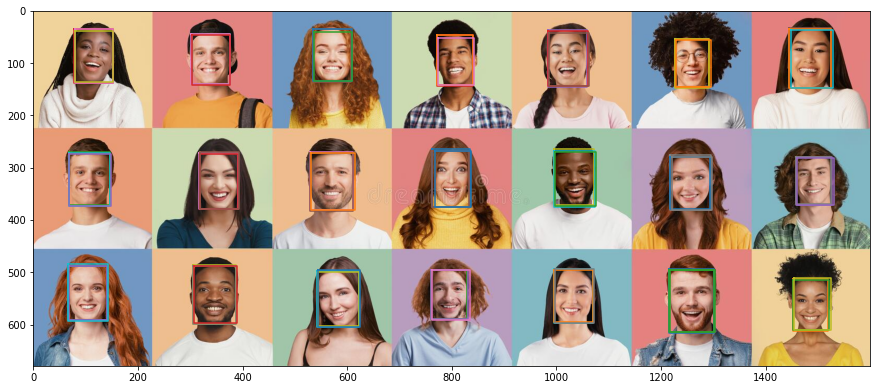

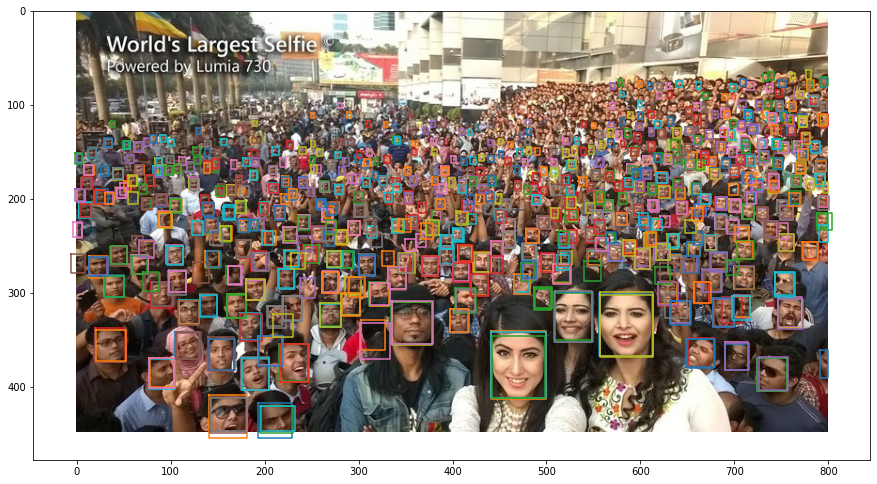

In [62]:
for img, (dets, lndms) in detections_dict_merged.items():
    
    plt.figure(figsize=(15,15))
    
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    for det in dets:
        x0, y0, x1, y1, _ = det
        plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0])
    plt.show()

In [120]:
IOU_TRESH_LNDMS = 0.8
IOU_TRESH = 0.5
MIN_VOTES = 1

detections_dict_aggregated = dict()

for img, (dets, lndms) in detections_dict_merged.items():
    landmarks_mask = list(map(lambda l: l[0] >= 0, lndms))
    dets = np.array(dets)
    lndms = np.array(lndms)
    
    keep = nms_landmarks(dets, landmarks_mask, IOU_TRESH_LNDMS, min_votes=MIN_VOTES)
    dets, lndms = dets[keep], lndms[keep]
    
    keep = nms_landmarks(dets, landmarks_mask, IOU_TRESH)
    
    detections_dict_aggregated[img] = [dets[keep], lndms[keep]]

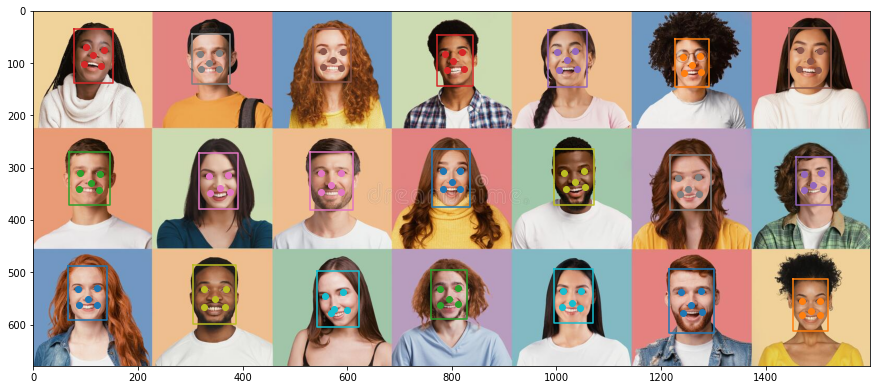

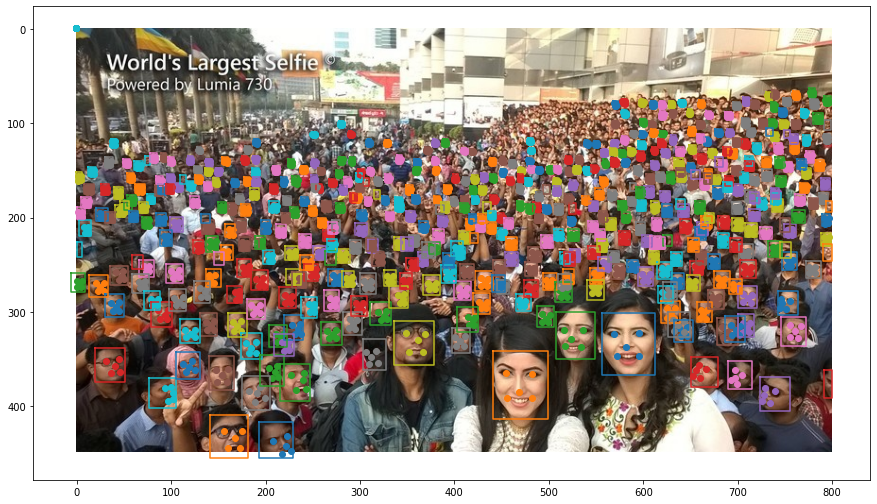

In [118]:
for img, (dets, lndms) in detections_dict_aggregated.items():
    
    plt.figure(figsize=(15,15))
    
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    for det, l in zip(dets, lndms):
        x0, y0, x1, y1, _ = det
        plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0])
        plt.scatter(l[::2], l[1::2])
    
    plt.show()

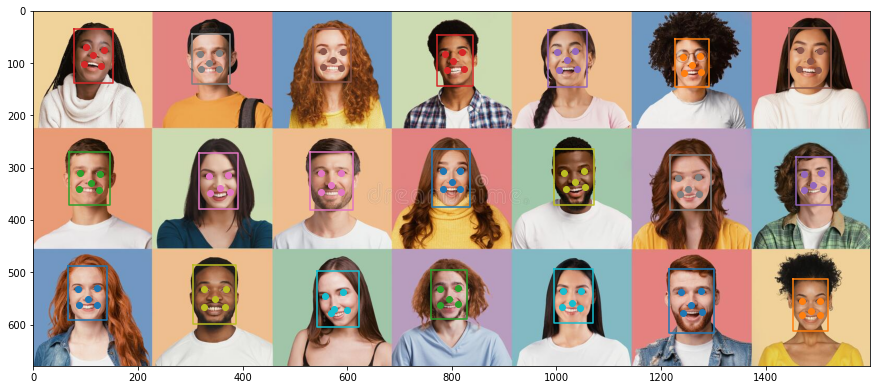

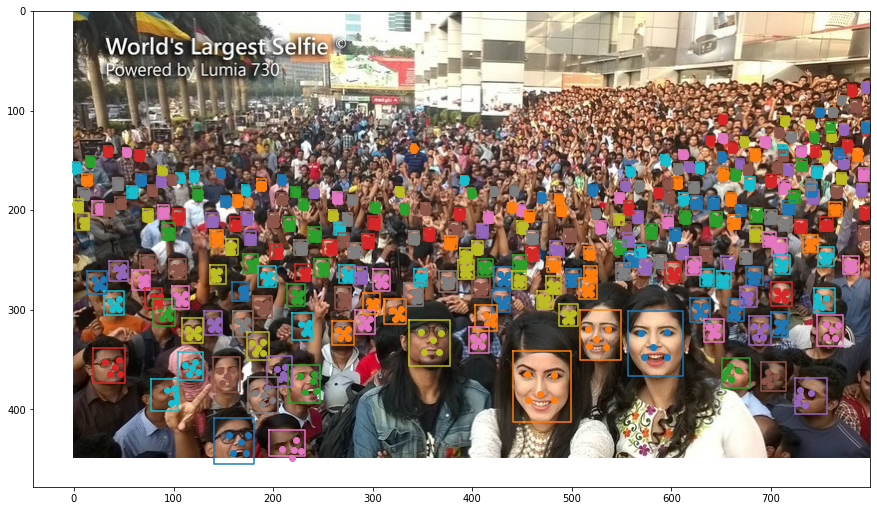

In [121]:
IOU_TRESH_LNDMS = 0.8
IOU_TRESH = 0.5
MIN_VOTES = 2

detections_dict_aggregated = dict()

for img, (dets, lndms) in detections_dict_merged.items():
    landmarks_mask = list(map(lambda l: l[0] >= 0, lndms))
    dets = np.array(dets)
    lndms = np.array(lndms)
    
    keep = nms_landmarks(dets, landmarks_mask, IOU_TRESH_LNDMS, min_votes=MIN_VOTES)
    dets, lndms = dets[keep], lndms[keep]
    
    keep = nms_landmarks(dets, landmarks_mask, IOU_TRESH)
    
    detections_dict_aggregated[img] = [dets[keep], lndms[keep]]

for img, (dets, lndms) in detections_dict_aggregated.items():
    
    plt.figure(figsize=(15,15))
    
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    for det, l in zip(dets, lndms):
        x0, y0, x1, y1, _ = det
        plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0])
        plt.scatter(l[::2], l[1::2])
    
    plt.show()